# Replicating the Community Ice Sheet Model v2.1 Halfar Dome Benchmark with Decapodes

The Decapodes framework takes high-level representations of physics equations and automatically generates solvers.

We do so by translating equations from vector calculus notation to the "discrete exterior calculus" (DEC). This process is roughly about recognizing whether physical quantities represent scalar or vector quantities, and recognizing whether differential operators represent gradient, divergence, and so on.

In this benchmark, we will implement the "small slope approximation" of glacial dynamics used by P. Halfar in his 1981 work "On the dynamics of the ice sheets" by taking his original formulation, translating it into the DEC, then providing a mesh and initial conditions.

The initial conditions used here are exactly those considered by W. H. Lipscomb et al. in "Description And Evaluation of the Community Ice Sheet Model (CISM) v2.1" (2019).

In [2]:
# AlgebraicJulia Dependencies
using Catlab
using Catlab.Graphics
using CombinatorialSpaces
using Decapodes

# External Dependencies
using Pkg
using MLStyle
using MultiScaleArrays
using LinearAlgebra
using OrdinaryDiffEq
using JLD2
using SparseArrays
using Statistics
using GLMakie
using BenchmarkTools
using GeometryBasics: Point2
Point2D = Point2{Float64};


<img src="halfar_eq2.jpg" alt="Halfar Equation 2" style="width:800px">

We will translate Halfar's equation into the DEC below. Although the equation given by Halfar is dense, this notation does not allow you to see which operators represent divergence, which components represent diffusivity constants, and so on.

In the DEC, gradients are generalized by the exterior derivative "d". Given scalar-data, d gives the slope along edges in our mesh. Similarly, the operator (⋆, d, ⋆) generalizes divergence.

In Halfar's equation there is a term corresponding to the magnitude of the slope, but it is not clear where this quantity is to be defined. Is it a scalar-like quantity, or a vector like quantity? In the DEC translation, we take the gradient of h, d(h), and use the "sharp" operator to define it on points in the domain, where we then take its magnitude, then perform an averaging to define it along edges.

The front-most term defines a quantity - depending on the strain of the ice - that controls the rate at which ice diffuses. Since this computation is rather separate from the rest of the computations involving our differential operators, we will call it "Gamma" here, and define it in a later component Decapode.

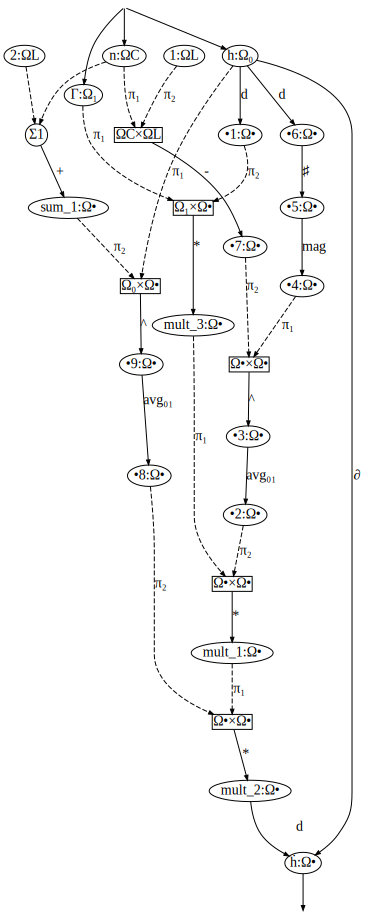

In [5]:
####################
# Define the model #
####################

# Equation 2 from Halfar, P. ON THE DYNAMICS OF THE ICE SHEETS. (1981),
# translated into the exterior calculus.
halfar_eq2 = @decapode begin
  h::Form0
  Γ::Form1
  n::Constant

  ḣ == ∂ₜ(h)
  ḣ == ∘(⋆, d, ⋆)(Γ * d(h) * avg₀₁(mag(♯(d(h)))^(n-1)) * avg₀₁(h^(n+2)))
end

to_graphviz(halfar_eq2)


<img src="glen_law1.jpg" alt="Glen's Law" style="width:800px">


This is "Glen's Flow Law." It states that the strain rate of a sheet of ice can be related to applied stress via a power law. Below, we encode the formulation as it is usually given in the literature, depending explicitly on the gravitational constant, g, for example.

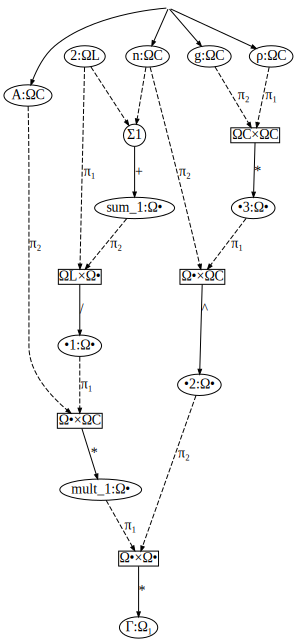

In [4]:
# Equation 1 from Glen, J. W. THE FLOW LAW OF ICE: A discussion of the
# assumptions made in glacier theory, their experimental foundations and
# consequences. (1958)
glens_law = @decapode begin
  Γ::Form1
  (A,ρ,g,n)::Constant
  
  Γ == (2/(n+2))*A*(ρ*g)^n
end

to_graphviz(glens_law)


We now need some way to compose these physics equations together. Since this physics is rather small, and there are no naming conflicts of physical quantities, this composition is also rather simple.

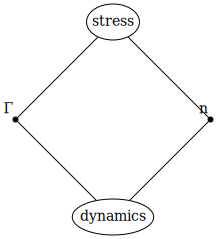

In [6]:
#####################
# Compose the model #
#####################

ice_dynamics_composition_diagram = @relation () begin
  dynamics(Γ,n)
  stress(Γ,n)
end
to_graphviz(ice_dynamics_composition_diagram, box_labels=:name, junction_labels=:variable, prog="circo")


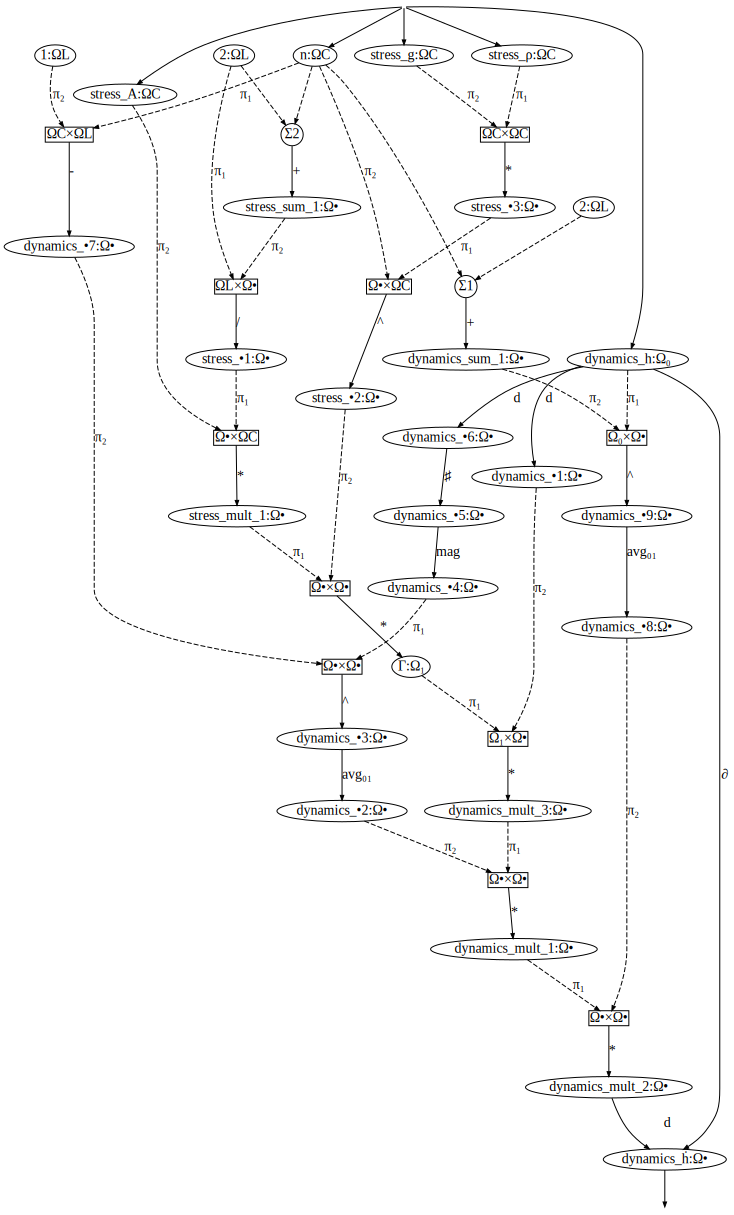

In [8]:
# Plug in our Decapodes to the composition pattern.
ice_dynamics_cospan = oapply(ice_dynamics_composition_diagram,
  [Open(halfar_eq2, [:Γ,:n]),
   Open(glens_law, [:Γ,:n])])

ice_dynamics = apex(ice_dynamics_cospan)
to_graphviz(ice_dynamics)


We have a representation of our composed physics. Now, we need to specify that these dynamics occur in 2 dimensions.

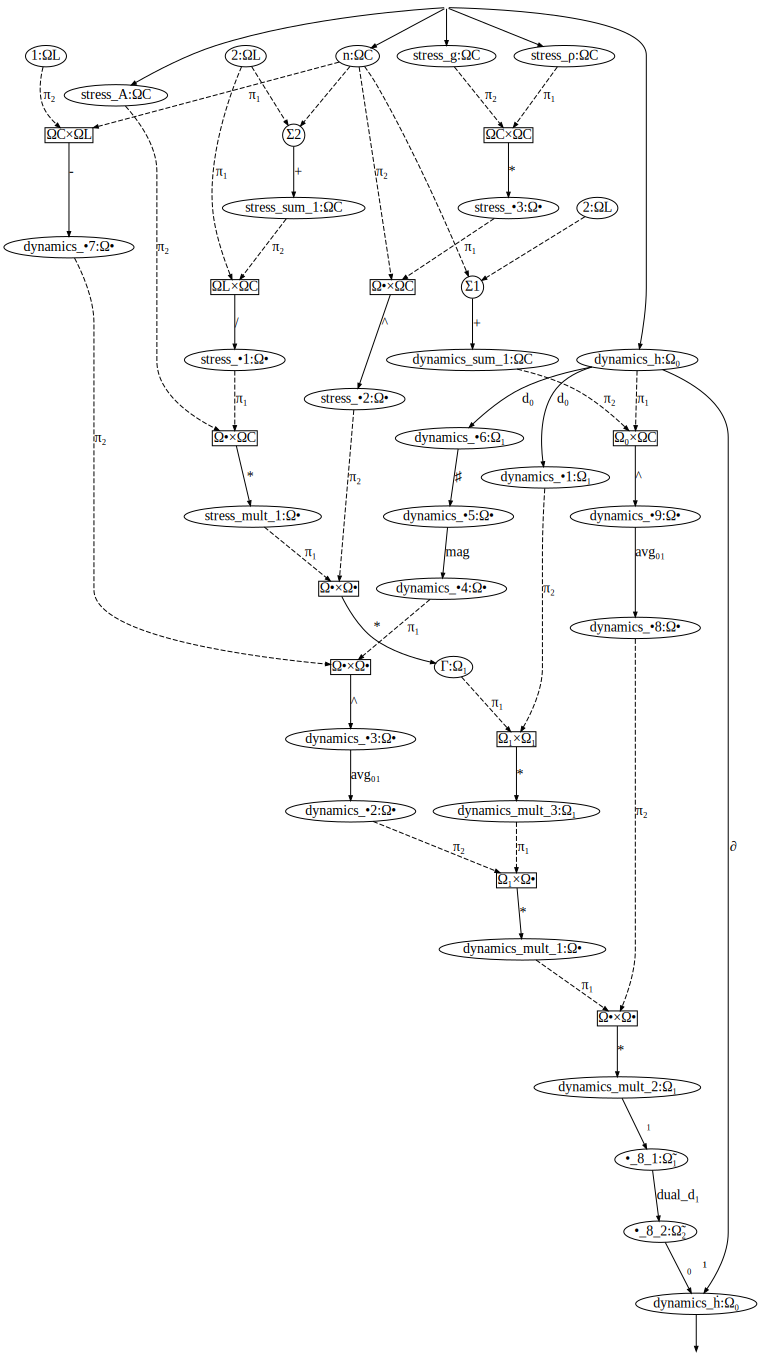

In [10]:
#######################
# Provide a Semantics #
#######################

# Interpret this multiphysics diagram in the 2D exterior calculus.

ice_dynamics2D = expand_operators(ice_dynamics)
infer_types!(ice_dynamics2D)
resolve_overloads!(ice_dynamics2D)
to_graphviz(ice_dynamics2D)


We are done encoding our dynamics. Now, we need to provide a mesh,  initial data to use for our quantities, and what functions to use for our differential operators.

Our mesh library, CombinatorialSpaces, can interpret arbitrary .OBJ files to run our dynamics on. Here, we use a script that generates a triangulated grid of the resolution used in the CISM benchmark. Note though that the "resolution" of a triangulated and non-triangulated grid is difficult to directly compare.

In [12]:
###################
# Define the mesh #
###################

include("../../grid_meshes.jl")
s′ = triangulated_grid(60_000,100_000,2_000,2_000,Point3D)
s = EmbeddedDeltaDualComplex2D{Bool, Float64, Point3D}(s′)
subdivide_duals!(s, Barycenter())
x̄ = mean(p -> p[1], point(s))
ȳ = mean(p -> p[2], point(s))

wf = wireframe(s)
save("ice_mesh.png", wf)


<img src="ice_mesh.png" alt="Wireframe of the Domain" style="width:800px">

In [14]:
########################################################
# Define constants, parameters, and initial conditions #
########################################################

# These are the initial conditions to the Halfar Dome test case that the
# Community Ice Sheet Model uses.
R₀ = 60_000 * sqrt(0.125)
H = 2_000 * sqrt(0.125)

n = 3
g = 9.8101
ρ = 910
alpha = 1/9
beta = 1/18
flwa = 1e-16
A = fill(1e-16, ne(s))

Gamma = 2.0/(n+2) * flwa * (ρ * g)^n
t0 = (beta/Gamma) * (7.0/4.0)^3 * (R₀^4 / H^7)

# This is the analytic solution for comparison.
# It is ported over from the CISM code for comparison's sake,
# and we will use it to set initial conditions.
function height_at_p(x,y,t)
  tr = (t + t0) / t0
  r = sqrt((x - x̄)^2 + (y - ȳ)^2)
  r = r/R₀
  inside = max(0.0, 1.0 - (r / tr^beta)^((n+1.0) / n))
  H * inside^(n / (2*n + 1)) / tr^alpha
end

# Set the initial conditions for ice sheet height:
# Ice height is a primal 0-form. i.e. valued at vertices.
h₀ = map(x -> height_at_p(x[1], x[2], 0), point(s′))
fig = mesh(s′, color=h₀, colormap=:jet)
save("ice_initial_conditions.png", fig)

<img src="ice_initial_conditions.png" alt="Initial Conditions" style="width:800px">

In [15]:
# Store these values to be passed to the solver.
u₀ = construct(PhysicsState, [VectorForm(h₀)], Float64[], [:dynamics_h])
constants_and_parameters = (
  n = n,
  stress_ρ = ρ,
  stress_g = g,
  stress_A = A)


(n = 3, stress_ρ = 910, stress_g = 9.8101, stress_A = [1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16  …  1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16, 1.0e-16])

We provide here the mapping from symbols to differential operators. As more of the differential operators of the DEC are implemented, they are upstreamed to the Decapodes and CombinatorialSpaces libraries. Of course, users can also provide their own implementations of these operators and others as they see fit.

In [16]:
#############################################
# Define how symbols map to Julia functions #
#############################################

function generate(sd, my_symbol; hodge=GeometricHodge())
  # We pre-allocate matrices that encode differential operators.
  ♯_m = ♯_mat(sd, AltPPSharp())
  # This averaging operator is scheduled to be upstreamed to the main repository.
  # We will leave it here for the time being.
  I = Vector{Int64}()
  J = Vector{Int64}()
  V = Vector{Float64}()
  for e in 1:ne(sd)
      append!(J, [sd[e,:∂v0],sd[e,:∂v1]])
      append!(I, [e,e])
      append!(V, [0.5, 0.5])
  end
  avg_mat = sparse(I,J,V)
  op = @match my_symbol begin
    :♯ => x -> begin
      ♯_m * x
  end
    :mag => x -> begin
      norm.(x)
    end
    :avg₀₁ => x -> begin
      avg_mat * x
    end
    :^ => (x,y) -> x .^ y
    :* => (x,y) -> x .* y
    :abs => x -> abs.(x)
    :show => x -> begin
      println(x)
      x
    end
    x => error("Unmatched operator $my_symbol")
  end
  return (args...) -> op(args...)
end

generate (generic function with 1 method)

The `gensim` function takes our high-level representation of the physics equations and produces compiled simulation code. It performs optimizations such as allocating memory for intermediate variables, and so on.

In [18]:
#######################
# Generate simulation #
#######################

sim = eval(gensim(ice_dynamics2D))
fₘ = sim(s, generate)


(::var"#f#57"{Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, Vector{Float64}, var"#47#55"{var"#43#51"}, var"#47#55"{var"#42#50"{SparseMatrixCSC{Float64, Int64}}}, var"#47#55"{var"#41#49"}, var"#47#55"{var"#40#48"{SparseMatrixCSC{Point3{Float64}, Int64}}}, Diagonal{Float64, Vector{Float64}}, SparseMatrixCSC{Int64, Int64}, SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Int64, Int64}}) (generic function with 1 method)

Julia is a "Just-In-Time" compiled language. That means that functions are compiled the first time they are called, and later calls to those functions skip this step. To get a feel for just how fast this simulation is, we will run the dynamics twice, once for a very short timespan to trigger pre-compilation, and then again for the actual dynamics.

In [19]:
##########################
# Pre-compile simulation #
##########################

# Julia will pre-compile the generated simulation the first time it is run.
@info("Precompiling Solver")
# We run for a short timespan to pre-compile.
prob = ODEProblem(fₘ, u₀, (0, 1e-8), constants_and_parameters)
soln = solve(prob, Tsit5())
soln.retcode != :Unstable || error("Solver was not stable")


┌ Info: Precompiling Solver
└ @ Main c:\Users\lukel\Prgming\Decapodes.jl\examples\climate\cism.ipynb:6


true

In [20]:
##################
# Run simulation #
##################
tₑ = 200

# This next run should be fast.
@info("Solving")
prob = ODEProblem(fₘ, u₀, (0, tₑ), constants_and_parameters)
soln = solve(prob, Tsit5())
@show soln.retcode
@info("Done")


┌ Info: Solving
└ @ Main c:\Users\lukel\Prgming\Decapodes.jl\examples\climate\cism.ipynb:7


soln.retcode = SciMLBase.ReturnCode.Success


┌ Info: Done
└ @ Main c:\Users\lukel\Prgming\Decapodes.jl\examples\climate\cism.ipynb:11


We can benchmark the compiled simulation with `@btime`. This macro runs many samples of the simulation function so we get an accurate estimate of the simulation time. It takes only **67 milliseconds** to run the entire simulation. These results are obtained on a 2016 Windows Surfacebook laptop.

In [21]:
#######################
# Time the simulation #
#######################

@btime soln = solve(prob, Tsit5())


  67.748 ms (6386 allocations: 49.76 MiB)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 28-element Vector{Float64}:
   0.0
   0.00048325434495301707
   0.005315797794483188
   0.05364123228978489
   0.2980177635503396
   0.806873048757719
   1.5627116382223352
   2.5909821472142998
   4.001412545681896
   5.873535833958046
   ⋮
  64.35151328958564
  76.48000871456102
  90.35980456498348
 105.37887525777296
 123.14249943053203
 143.04823491382817
 166.01304376498248
 191.95464911095308
 200.0
u: 28-element Vector{PhysicsState{VectorForm{Float64}, Float64}}:
 PhysicsState{VectorForm{Float64}, Float64}(VectorForm{Float64}[VectorForm{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])], Float64[], [1581], [:dynamics_h])
 PhysicsState{VectorForm{Float64}, Float64}(VectorForm{Float64}[VectorForm{Float64}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])], Float64[], [1581], [:dynamics_h

In [22]:
# Save the solution information to a file.
@save "ice_dynamics2D.jld2" soln


We recall that these dynamics are of the "shallow slope" and "shallow ice" approximations. So, at the edge of our parabolic dome of ice, we expect increased error as the slope increases. On the interior of the dome, we expect the dynamics to match more closely that given by the analytic model.

<img src="halfar_small_grad_approximation.jpg" alt="Halfar Small Ice Approximation Quote" style="width:800px">

In [24]:
# Plot the final conditions
function plot_final_conditions()
  fig = Figure()
  ax = Axis(fig[1,1],
    title="Modeled thickness (m) at time 200.0",
    aspect=0.6)
  msh = mesh!(ax, s′, color=findnode(soln(200.0), :dynamics_h), colormap=:jet)
  Colorbar(fig[1,2], msh)
  fig
end
fig = plot_final_conditions()
save("ice_numeric_solution.png", fig)


<img src="ice_numeric_solution.png" alt="Numerical Solution" style="width:800px">

In [25]:
# Plot the final conditions according to the analytic solution.
function plot_analytic()
  hₐ = map(x -> height_at_p(x[1], x[2], 200.0), point(s′))
  fig = Figure()
  ax = Axis(fig[1,1],
    title="Analytic thickness (m) at time 200.0",
    aspect=0.6)
  msh = mesh!(ax, s′, color=hₐ, colormap=:jet)
  Colorbar(fig[1,2], msh)
  fig
end
fig = plot_analytic()
save("ice_analytic_solution.png", fig)


<img src="ice_analytic_solution.png" alt="Analytic Solution" style="width:800px">

In [29]:
# Plot the error.
function plot_error()
  hₐ = map(x -> height_at_p(x[1], x[2], 200.0), point(s′))
  h_diff = findnode(soln(tₑ), :dynamics_h) - hₐ
  extrema(h_diff)
  fig = Figure()
  ax = Axis(fig[1,1],
    title="Modeled thickness - Analytic thickness at time 200.0",
    aspect=0.6)
  msh = mesh!(ax, s′, color=h_diff, colormap=:jet)
  Colorbar(fig[1,2], msh)
  fig
end
fig = plot_error()
save("ice_error.png", fig)


<img src="ice_error.png" alt="Numeric Solution - Analytic Solution" style="width:800px">

We compute below that the maximum absolute error is approximately 89 meters. We observe that this error occurs exactly on the edge of the dome, which we expect given that this is where the "shallow slope approximation" breaks down, and the updates to our physical quantities should become more unstable. This pattern likewise occurs in the CISM benchmarks.

In [34]:
# Compute max absolute error:
hₐ = map(x -> height_at_p(x[1], x[2], 200.0), point(s′))
h_diff = findnode(soln(tₑ), :dynamics_h) - hₐ
maximum(abs.(h_diff))

89.25883061368137

We compute RMSE as well, *excluding where the ice distribution is 0 in the analytic solution.* We compute about 10.4 RMSE using this technique. The CISM benchmark reports 6.43 and 9.06 RMSE for their two solver implementations.

In [44]:
# Compute RMSE
hₐ = map(x -> height_at_p(x[1], x[2], 200.0), point(s′))
nonzeros = findall(!=(0), hₐ)
h_diff = findnode(soln(tₑ), :dynamics_h) - hₐ
rmse = sqrt(sum(map(x -> x*x, h_diff[nonzeros])) / length(nonzeros))

hₐ = map(x -> height_at_p(x[1], x[2], 200.0), point(s′))
#nonzeros = findall(!=(0), hₐ)
h_diff = findnode(soln(tₑ), :dynamics_h) - hₐ
rmse = sqrt(sum(map(x -> x*x, h_diff)) / length(h_diff))


10.0843152130432

In [31]:
# Create a gif
begin
  frames = 100
  fig, ax, ob = mesh(s′, color=findnode(soln(0), :dynamics_h), colormap=:jet, colorrange=extrema(findnode(soln(tₑ), :dynamics_h)))
  Colorbar(fig[1,2], ob)
  record(fig, "ice_dynamics_cism.gif", range(0.0, tₑ; length=frames); framerate = 30) do t
    ob.color = findnode(soln(t), :dynamics_h)
  end
end

"ice_dynamics_cism.gif"

<img src="ice_dynamics_cism.gif" alt="Ice Dynamics" style="width:800px">

For comparison's sake, we paste the results produced by CISM below. We observe that the error likewise accumulates around the edge of the dome, with more accurate predictions on the interior. We note that our simulation produces slight over-estimates on the interior, but there are further strategies that one can employ to increase accuracy, such as tweaking the error tolerance of the solver, and so on.

Not that since the DEC is based on triangulated meshes, the "resolution" of the CISM benchmark and the Decapodes implementation cannot be directly compared. An advantage of the DEC is that we do not need to operate on uniform grids. For example, you could construct a mesh that is finer along the dome edge, where you need more resolution, and coarser as you are farther away from the reach of the ice.

<img src="cism_results.png" alt="CISM Results" style="width:800px">

We saw in this document how to create performant and accurate simulations in the Decapodes framework, and compared against the CISM library . Although we do not expect to be both more performant and accurate compared to every hand-crafted simulation, Decapodes makes up for this difference in terms of development time, flexibility, and composition. For example, the original implementation of the Decapodes shallow ice model took place over a couple of afternoons during a hackathon.

Since Decapodes targets high-level representations of physics, it is uniquely suited to incorporating knowledge from subject matter experts to increase simulation accuracy. This process does not require an ice dynamics expert to edit physics equations that have already been weaved into solver code.

Further improvements to the Decapodes library are made continuously. We are creating implementations of DEC operators that are constructed and execute faster. And we are in the beginning stages of 3D simulations using the DEC.